In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re # Using regular expressions for robust sorting
import random
import tensorflow as tf

data_folder = "quest_training_data/"

In [ ]:
#Wanna do a quick check to see if TensorFlow can access the GPU
from tensorflow.python.client import device_lib
import tensorflow as tf

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

print(tf.__version__)

In [2]:


# --- Seeding for reproducibility ---
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

needed_cols = [
    'TimeStamp',
    'Meta_R_Index_Distal_GLOBAL_X',
    'Meta_R_Index_Distal_GLOBAL_Y',
    'Meta_R_Index_Distal_GLOBAL_Z',
    'KeyPressFlag',
    'Pressed_Letter'
]

# --- Configuration ---
data_folder = "quest_training_data/"

# --- This list will hold the final, clean DataFrames for each session ---
all_session_dfs = []

print("Starting Smart Data Concatenation (per participant)...")

# --- Discover Participant Folders ---
try:
    participant_folders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
except FileNotFoundError:
    print(f"ERROR: The directory '{data_folder}' was not found. Please check the path.")
    participant_folders = []

print(f"Found {len(participant_folders)} participant folders to process.\n")

# --- Main Processing Loop (Iterating through each participant) ---
for folder_path in participant_folders:
    participant_id = os.path.basename(folder_path)
    print(f"--- Processing Participant: {participant_id} ---")

    search_pattern = os.path.join(folder_path, '*.csv')
    csv_files = glob.glob(search_pattern)

    if not csv_files:
        print("  -> No CSV files found, skipping.\n")
        continue

    # --- Sort files chronologically using the timestamp in the filename ---
    def get_sort_key(filepath):
        matches = re.findall(r'(\d+\.\d+)\.csv', os.path.basename(filepath))
        return float(matches[-1]) if matches else 0

    csv_files.sort(key=get_sort_key)

    # Concatenate all files FOR THIS PARTICIPANT ONLY
    session_dfs = [pd.read_csv(file, usecols=needed_cols, low_memory=False) for file in csv_files]
    if session_dfs:
        session_df = pd.concat(session_dfs, ignore_index=True)
        all_session_dfs.append(session_df)
        print(f"  -> Success! Created a session DataFrame with shape: {session_df.shape}")


print("\n--- Smart Concatenation Complete ---")
print(f"Processed {len(all_session_dfs)} total sessions.")



Starting Smart Data Concatenation (per participant)...
Found 2 participant folders to process.

--- Processing Participant: ptx_02_x2 ---
  -> Success! Created a session DataFrame with shape: (276698, 6)
--- Processing Participant: ptx_03_x2 ---
  -> Success! Created a session DataFrame with shape: (264286, 6)

--- Smart Concatenation Complete ---
Processed 2 total sessions.


In [6]:
# --- Feature Engineering (Applied to each session individually) ---
processed_sessions = []
for session_df in all_session_dfs:
    # We need all three axes for feature calculation
    feature_cols = [
        'TimeStamp',
        'Meta_R_Index_Distal_GLOBAL_X',
        'Meta_R_Index_Distal_GLOBAL_Y',
        'Meta_R_Index_Distal_GLOBAL_Z',
        'Pressed_Letter'
    ]
    label_col = 'KeyPressFlag'
    
    required_cols = feature_cols + [label_col]
    if not all(col in session_df.columns for col in required_cols):
        continue # Skip if a session is missing data
        
    processed_df = session_df[required_cols].copy()
    
    delta_time = processed_df['TimeStamp'].diff().replace(0, np.nan).ffill()


    # Calculate Velocity & Acceleration for all axes
    for axis in ['X', 'Y', 'Z']:
        pos_col = f'Meta_R_Index_Distal_GLOBAL_{axis}'
        vel_col = f'vel_{axis.lower()}'
        accel_col = f'accel_{axis.lower()}'
        
        processed_df[vel_col] = processed_df[pos_col].diff() / delta_time
        processed_df[accel_col] = processed_df[vel_col].diff() / delta_time
    
    #processed_df.dropna(inplace=True)

    # 1. Replace any infinite values (positive or negative) with NaN
    processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 2. NOW drop all NaN values (which now includes the replaced infinities)
    processed_df.dropna(inplace=True)
    
    processed_sessions.append(processed_df)

# --- Final Step: Combine the CLEANED sessions into one master DataFrame for windowing ---
if processed_sessions:
    master_df = pd.concat(processed_sessions, ignore_index=True)
    print("\n--- Feature Engineering Complete ---")
    print("Shape of the final master DataFrame for training:", master_df.shape)
else:
    print("\nNo data to process after feature engineering.")


--- Feature Engineering Complete ---
Shape of the final master DataFrame for training: (528987, 12)


Windowing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# --- Step 1: Prepare Data for Windowing ---
feature_columns = [
    'Meta_R_Index_Distal_GLOBAL_Y', # Position Y
    'vel_y',                        # Velocity Y
    'accel_y',                      # Acceleration Y
    'Meta_R_Index_Distal_GLOBAL_Z', # Position Z
    'vel_z',                        # Velocity Z
    'accel_z'                       # Acceleration Z
]

# The rest of the script adapts automatically to the new feature count
timeseries_data = master_df[['KeyPressFlag'] + feature_columns].to_numpy()

# --- Setting window size to 100 to start off with
window_size = 100

# --- Step 2: Create Time-Series Windows ---
def make_timeseries_instances(time_series, window_size):
    """Chops the data into overlapping windows."""
    X = []
    y = []
    for i in range(window_size, time_series.shape[0]):
        X.append(time_series[i-window_size:i, 1:])
        y.append(time_series[i, 0])
    return np.array(X), np.array(y).astype(int)

print("Creating time-series windows...")
X_windowed, y_windowed = make_timeseries_instances(timeseries_data, window_size)
print("Shape of X_windowed (samples, timesteps, features):", X_windowed.shape)
print("Shape of y_windowed:", y_windowed.shape)

# --- Step 3: Split and Scale the Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("\nData successfully prepared with Y and Z-axis features.")

Creating time-series windows...
Shape of X_windowed (samples, timesteps, features): (528887, 100, 6)
Shape of y_windowed: (528887,)

Data successfully prepared with Y and Z-axis features.


Building model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
# --- Step 4: Build and Train the LSTM Model ---

print("\nBuilding the LSTM model...")
model = Sequential([
    # The LSTM layer processes the sequence. input_shape is (window_size, num_features)
    LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), unroll=True, name="lstm"),
    Dropout(0.5), # Dropout helps prevent overfitting
    # The final Dense layer gives a single output (tap or no-tap)
    Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# To handle the class imbalance, calculate class weights
# This penalizes the model more for missing the rare 'tap' events
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

print("\nTraining the LSTM model... (This may take a long time)")
# EarlyStopping will stop training if the model isn't improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.2, # Use part of the training data for validation - perhaps 20% is a good start
    class_weight=class_weights,
    callbacks=[early_stopping]
)


# --- Step 5: Evaluate the Final Model ---

print("\nEvaluating the final model on the test set...")
# We predict probabilities and use a threshold of 0.5 to get 0s and 1s
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nFinal LSTM Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Building the LSTM model...


c:\Users\SyMoN\.conda\envs\saad_classifier_312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model... (This may take a long time)
Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 254s 158ms/step - accuracy: 0.6138 - loss: 0.6486 - val_accuracy: 0.6496 - val_loss: 0.6175
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 183s 139ms/step - accuracy: 0.6507 - loss: 0.6189 - val_accuracy: 0.6623 - val_loss: 0.6020
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 200s 137ms/step - accuracy: 0.6640 - loss: 0.6038 - val_accuracy: 0.6787 - val_loss: 0.5862
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 185s 140ms/step - accuracy: 0.6762 - loss: 0.5927 - val_accuracy: 0.6891 - val_loss: 0.5749
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 199s 138ms/step - accuracy: 0.6876 - loss: 0.5809 - val_accuracy: 0.6928 - val_loss: 0.5704
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 180s 136ms/step - accuracy: 0.6971 - loss: 0.5707 - val_accuracy: 0.7027 - val_loss: 0.5598
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 205s 139ms/step - accuracy: 0.7066 - loss: 0.5610 - val_accuracy: 0.7125 - val_loss: 0.5499
Epoch 

Now saving the model and exporting it, before converting to onnx.

In [9]:
model.save('ltsm_tap_new.keras')  # Save the model for later use

In [10]:
import tensorflow as tf
# Load trained model
model = tf.keras.models.load_model('ltsm_tap_new.keras')

# Export it to a new directory
model.export('ltsm_tap_new_exported')

INFO:tensorflow:Assets written to: ltsm_tap_new_exported\assets


INFO:tensorflow:Assets written to: ltsm_tap_new_exported\assets


Saved artifact at 'ltsm_tap_new_exported'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1756661461264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1756661460880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1756661462992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1756661463376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1756661462416: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [14]:
# --- NEW CELL TO GET SCALER VALUES ---
# This cell should be run AFTER the cell where you define and fit the 'scaler' object.

print("--- Scaler Values for Unity ---")
print("Copy these arrays into your C# script.\n")

# The feature_columns list must be IDENTICAL to the one used for training
# to ensure the order of mean/scale values is correct.
# The order should be: [Y_pos, Y_vel, Y_accel, Z_pos, Z_vel, Z_accel]
feature_columns = [
    'Meta_R_Index_Distal_GLOBAL_Y',
    'vel_y',
    'accel_y',
    'Meta_R_Index_Distal_GLOBAL_Z',
    'vel_z',
    'accel_z'
]

# Check if the number of features matches the scaler's learned features
if len(feature_columns) != scaler.n_features_in_:
    print(f"ERROR: Mismatch in feature count!")
    print(f"Expected {scaler.n_features_in_} features, but feature_columns has {len(feature_columns)}.")
else:
    # The mean values, formatted for C#
    print("private readonly float[] scalerMean = new float[6] {", ", ".join(f"{val:.8f}f" for val in scaler.mean_), "};")

    # The scale (standard deviation) values, formatted for C#
    print("private readonly float[] scalerScale = new float[6] {", ", ".join(f"{val:.8f}f" for val in scaler.scale_), "};")



--- Scaler Values for Unity ---
Copy these arrays into your C# script.

private readonly float[] scalerMean = new float[6] { 0.86914025f, -0.00037746f, -0.03515386f, 0.32091813f, 0.00010341f, 0.04051685f };
private readonly float[] scalerScale = new float[6] { 0.04979967f, 0.17790756f, 44.22439719f, 0.02788436f, 0.14820831f, 36.96062780f };


Moving from tap detection to letter detection. First producing a visualisation. 

Found 260015 tap events to visualize.


c:\Users\SyMoN\.conda\envs\saad_classifier_312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


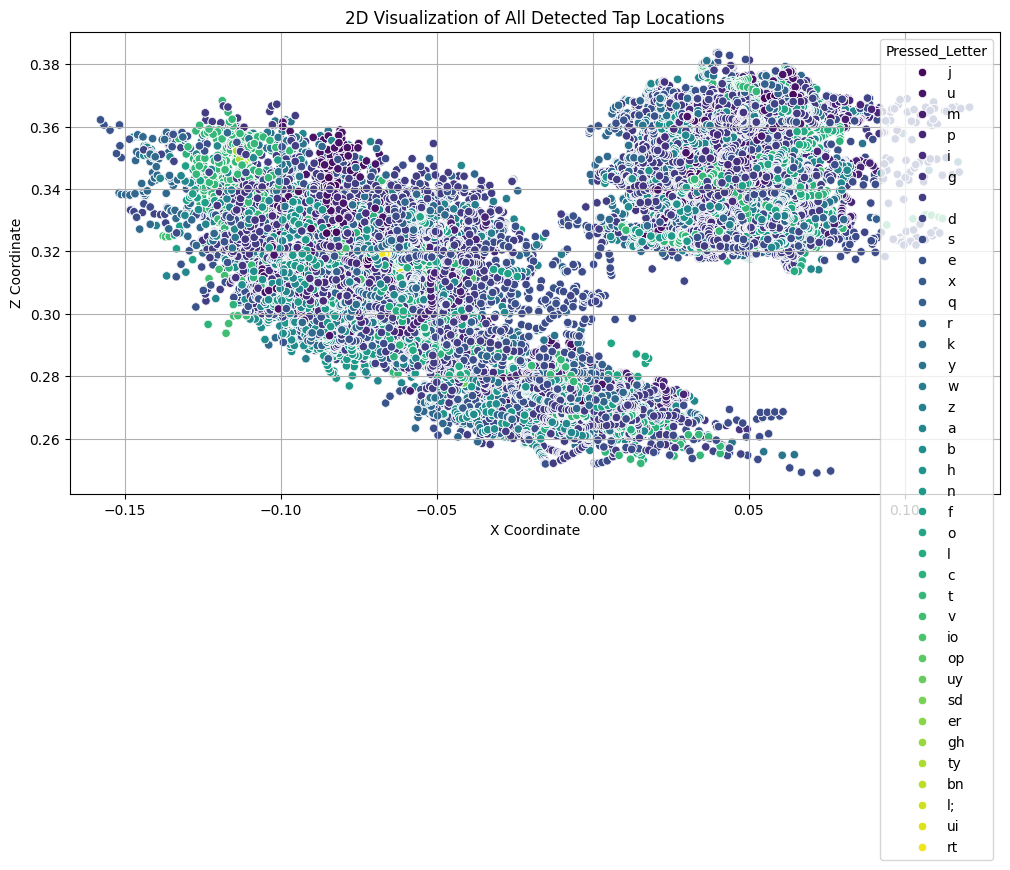

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure master_df is your fully processed dataframe from the previous step

# 1. Create a new dataframe containing ONLY the rows where a real tap occurred
tap_events_df = master_df[master_df['KeyPressFlag'] == 1].copy()

print(f"Found {len(tap_events_df)} tap events to visualize.")

# 2. Create a 2D scatter plot of the tap locations
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=tap_events_df,
    x='Meta_R_Index_Distal_GLOBAL_X',
    y='Meta_R_Index_Distal_GLOBAL_Z',
    hue='Pressed_Letter', # Color each point by the letter that was pressed
    palette='viridis',
    legend=True # Turning off legend for clarity as there will be many letters
)

plt.title('2D Visualization of All Detected Tap Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')
plt.grid(True)
plt.axis('equal') # Ensure the scaling of X and Z axes is the same
plt.show()

Visualisation 

--- Generating Model Performance Visualizations ---


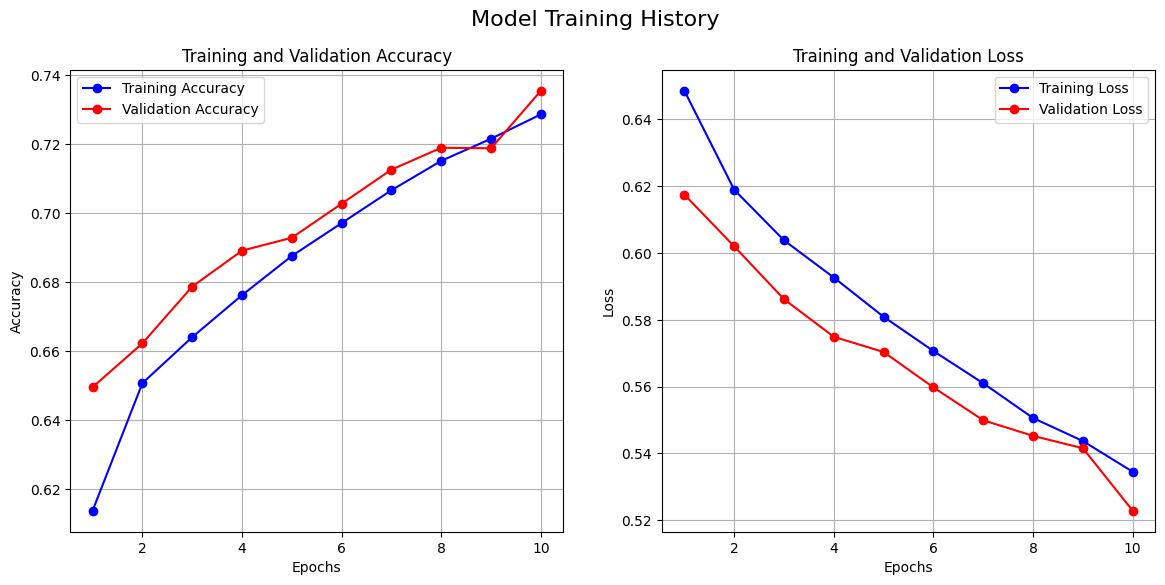

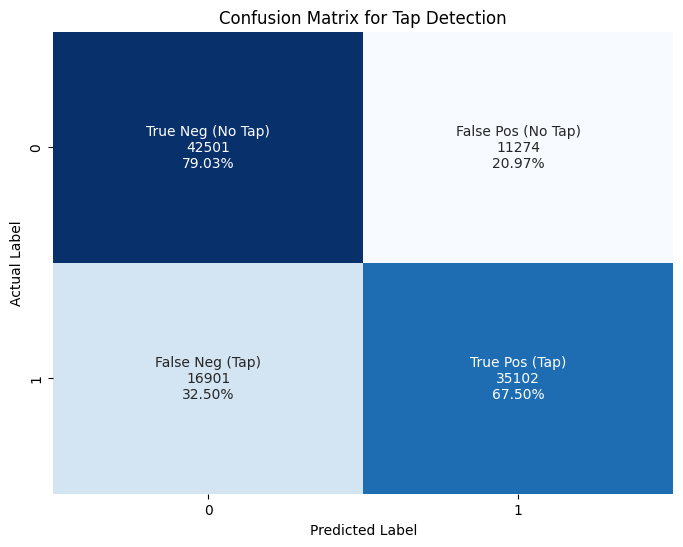


--- Classification Report ---
              precision    recall  f1-score   support

  No Tap (0)       0.72      0.79      0.75     53775
     Tap (1)       0.76      0.67      0.71     52003

    accuracy                           0.73    105778
   macro avg       0.74      0.73      0.73    105778
weighted avg       0.74      0.73      0.73    105778



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("--- Generating Model Performance Visualizations ---")

# --- 1. Plot Training & Validation Accuracy and Loss ---
# The 'history' object holds the metrics from each epoch during training
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training History', fontsize=16)
plt.show()


# --- 2. Plot a Detailed Confusion Matrix ---
# 'y_test' is the true labels, 'y_pred' is what our model predicted
cm = confusion_matrix(y_test, y_pred)

# For better visualization, we can show percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# The labels for our matrix
labels = ['True Neg (No Tap)', 'False Pos (No Tap)', 'False Neg (Tap)', 'True Pos (Tap)']
counts = [f'{value:0.0f}' for value in cm.flatten()]
percentages = [f'{value:.2%}' for value in cm_percent.flatten()]
final_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percentages)]
final_labels = np.asarray(final_labels).reshape(2,2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=final_labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Tap Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 3. Print a Detailed Classification Report ---
# This report gives precision, recall, and f1-score for each class
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Tap (0)', 'Tap (1)']))
